In [ ]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

In [ ]:
df = r"submission_sample.csv"
df = pd.read_csv(df)
df.head()

,srch_id,prop_id
0,1,3180
1,1,5543
2,1,14142
3,1,22393
4,1,24194


In [ ]:
train = r"preprocessed_train_data1.csv"
df_train = pd.read_csv(train)
df_train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,click_bool,gross_bookings_usd,booking_bool,day_of_week,month,hour_of_day,is_weekend,same_country,delta_star_rating,delta_price_usd
0,1,2013-04-04 08:32:15,12,187,3.374334,176.022659,219,893,3,3.5,...,0,NaN,0,3,4,8,0,0,-0.374334,-71.252659
1,1,2013-04-04 08:32:15,12,187,3.374334,176.022659,219,10404,4,4.0,...,0,NaN,0,3,4,8,0,0,0.625666,-5.282659
2,1,2013-04-04 08:32:15,12,187,3.374334,176.022659,219,21315,3,4.5,...,0,NaN,0,3,4,8,0,0,-0.374334,3.777341
3,1,2013-04-04 08:32:15,12,187,3.374334,176.022659,219,27348,2,4.0,...,0,NaN,0,3,4,8,0,0,-1.374334,426.747341
4,1,2013-04-04 08:32:15,12,187,3.374334,176.022659,219,29604,4,3.5,...,0,NaN,0,3,4,8,0,0,0.625666,-32.442659


In [ ]:
df_train[df_train['price_usd']>5000].count()

srch_id                        2871
date_time                      2871
site_id                        2871
visitor_location_country_id    2871
visitor_hist_starrating        2871
                               ... 
hour_of_day                    2871
is_weekend                     2871
same_country                   2871
delta_star_rating              2871
delta_price_usd                2871
Length: 61, dtype: int64

In [ ]:
test = r"test_set_VU_DM.csv"
df_test = pd.read_csv(test)
df_test.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Takes about 20 mins 0n 4.9 mil instances
def create_submission(model1, model2, Test_data, proba = False):
    import time
    start = time.time()
    
    Test = Test_data
    #predictions
    print("~ Making predictions")
    if proba == True:
        clickpreds = model1.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        
        Test['click_preds'] = pd.DataFrame(clickpreds)[1].values
        Test['booking_preds'] = pd.DataFrame(bookpreds)[1].values
    else:
        clickpreds = model1.predict(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict(Test.drop(['srch_id','prop_id'], axis = 1))
    
        Test['click_preds'] = clickpreds
        Test['booking_preds'] = bookpreds
    
    #Grab 4 columns from Test
    sub = Test[['srch_id','prop_id','click_preds','booking_preds']]
    #Weight booking column values
    
    if proba == True:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x*2 if x > 0 else x)
    else:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x+1 if x > 0 else x)
    #Total click & booking values, remove columns
    sub['total'] = sub['click_preds']+sub['booking_preds']
    sub.drop(['click_preds', 'booking_preds'], axis = 1, inplace = True)
    
    #Sort chunks of srch ids by 'total' value
    print(f"~ Sorting chunks of srch_ids: {(time.time()-start):.2f}s have passed")
    ids = sub['srch_id'].unique()
    sub1 = pd.DataFrame()
    k=0
    
    srch_id = []
    prop_id = []
    total = []
    for item in ids:
       
        df = sub[sub['srch_id'] == item].sort_values('total', ascending = False)
        srch_id.append(df['srch_id'].values)
        prop_id.append(df['prop_id'].values)
        total.append(df['total'].values)
    
        k+=1
        if not k%10000:
            print(f"{k}/{len(ids)} srch_ids, time elapsed: {(time.time() - start):.2f}s")

    #Unpack list of arrays
    print(f"~ Unpacking lists: {(time.time() - start):.2f}s elapsed")
    _srch_id = []
    for i in range(0,len(srch_id)):
        for k in range(0,len(srch_id[i])):
            _srch_id.append(srch_id[i][k])
    _prop_id = []
    for i in range(0,len(prop_id)):
        for k in range(0,len(prop_id[i])):
            _prop_id.append(prop_id[i][k])
    _total = []
    for i in range(0,len(total)):
        for k in range(0,len(total[i])):
            _total.append(total[i][k])
    
    #Create Dataframe from unpacked lists
    print(f"~ Creating Dataframe: {(time.time() - start):.2f}s elapsed")
    sub2 = pd.DataFrame(zip(_srch_id, _prop_id, _total),
               columns =['srch_id', 'prop_id','total'])
    
    sub1 = sub2[['srch_id','prop_id']]
    
    print(f"~ Finished. Total time: {(time.time() - start):.2f}")
    return(sub1, sub2)
    

In [ ]:
X_train = df_train.drop(['srch_id', 'prop_id','click_bool', 'booking_bool'], axis = 1)

#"Data-Time" is dropped since it is "object" format
#9 additional features with minimal impact are dropped so that the model works 
X_train = X_train.drop(['date_time','is_weekend','comp7_rate_percent_diff','comp7_inv','comp7_rate','comp6_rate','comp5_inv','comp2_inv', 'comp3_rate','comp6_rate_percent_diff'], axis=1)

Y1_train = df_train['click_bool']
Y2_train = df_train['booking_bool']

In [ ]:
LGBMclick = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 76)
LGBMbook = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 78)

In [ ]:
print(X_train.dtypes)


site_id                          int64
visitor_location_country_id      int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                  int64
prop_starrating                  int64
prop_review_score              float64
prop_brand_bool                  int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
position                         int64
price_usd                      float64
promotion_flag                   int64
srch_destination_id              int64
srch_length_of_stay              int64
srch_booking_window              int64
srch_adults_count                int64
srch_children_count              int64
srch_room_count                  int64
srch_saturday_night_bool         int64
srch_query_affinity_score      float64
orig_destination_distance      float64
random_bool                      int64
comp1_rate                     float64
comp1_inv                

In [ ]:
LGBMclick.fit(X_train, Y1_train)
LGBMbook.fit(X_train, Y2_train)

[LightGBM] [Info] Number of positive: 221879, number of negative: 4736468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4568
[LightGBM] [Info] Number of data points in the train set: 4958347, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044749 -> initscore=-3.060915
[LightGBM] [Info] Start training from score -3.060915
[LightGBM] [Info] Number of positive: 138390, number of negative: 4819957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4568
[LightGBM] [Info] Number of data points in the train set: 4958347, number of used features: 47
[LightGB

LGBMClassifier(n_estimators=78, scale_pos_weight=12)

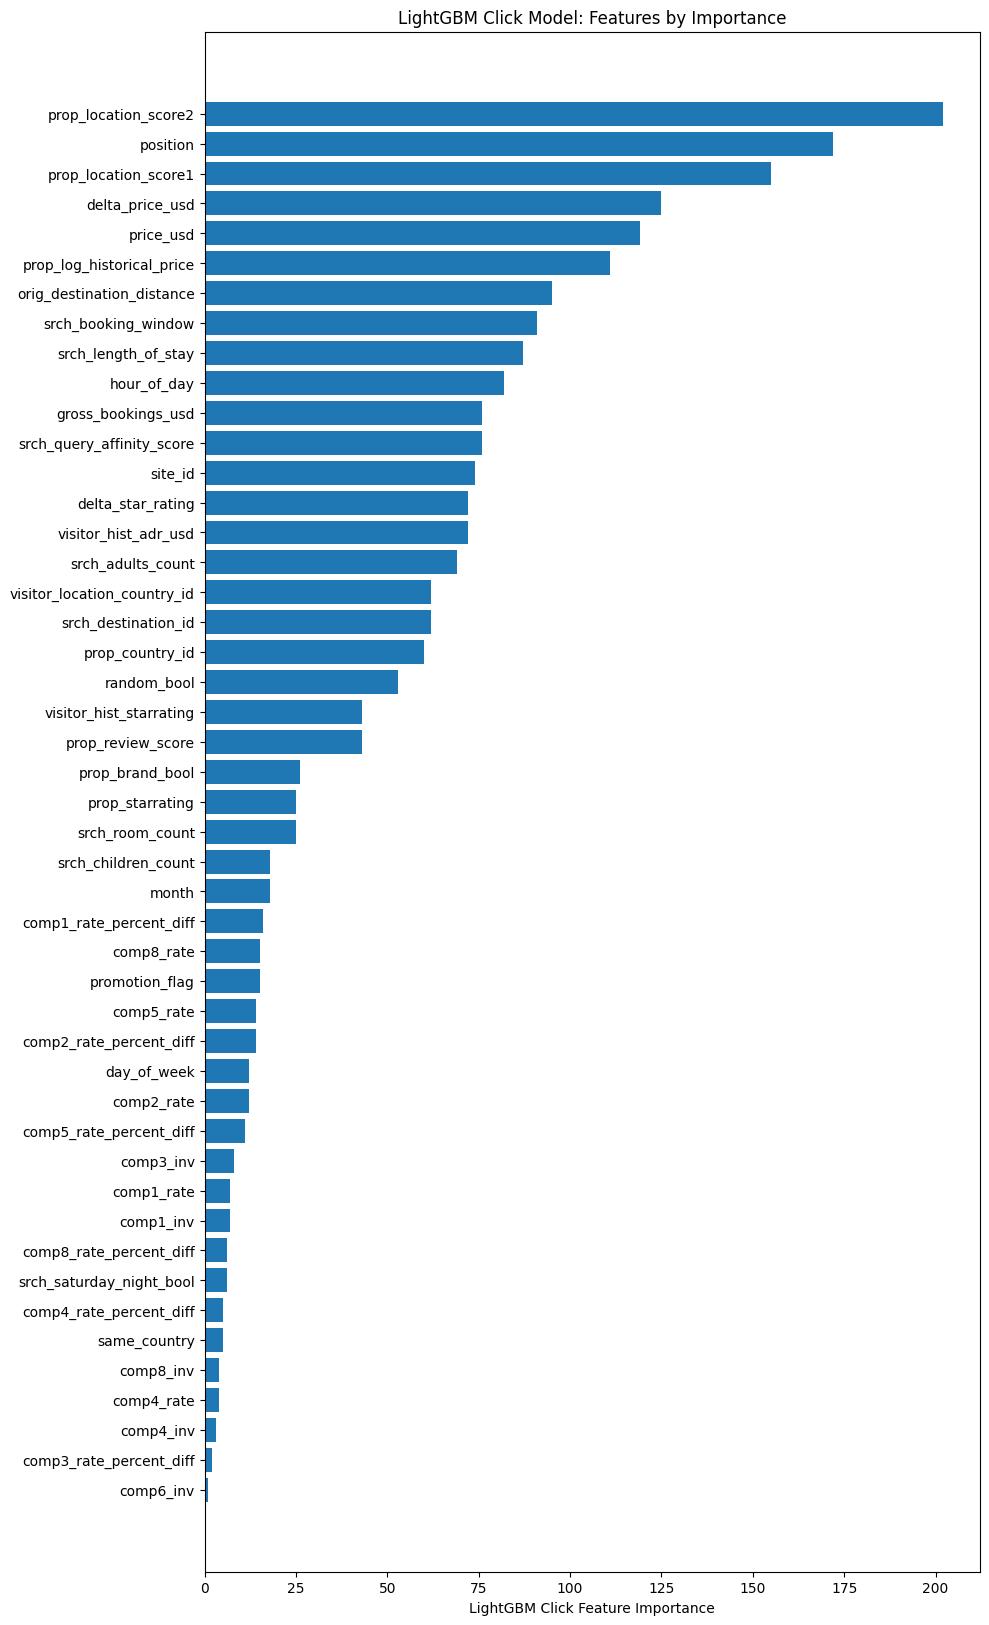

In [ ]:
import matplotlib.pyplot as plt

#Set the size of the plot
plt.figure(figsize=(10, 20))  # Width, Height in inches

#Sorting the indices of the features by importance
sorted_idx = LGBMclick.feature_importances_.argsort()

#Create a horizontal bar plot
plt.barh(X_train.columns[sorted_idx], LGBMclick.feature_importances_[sorted_idx])
plt.xlabel("LightGBM Click Feature Importance")
plt.title("LightGBM Click Model: Features by Importance")

#Show the plot
plt.show()


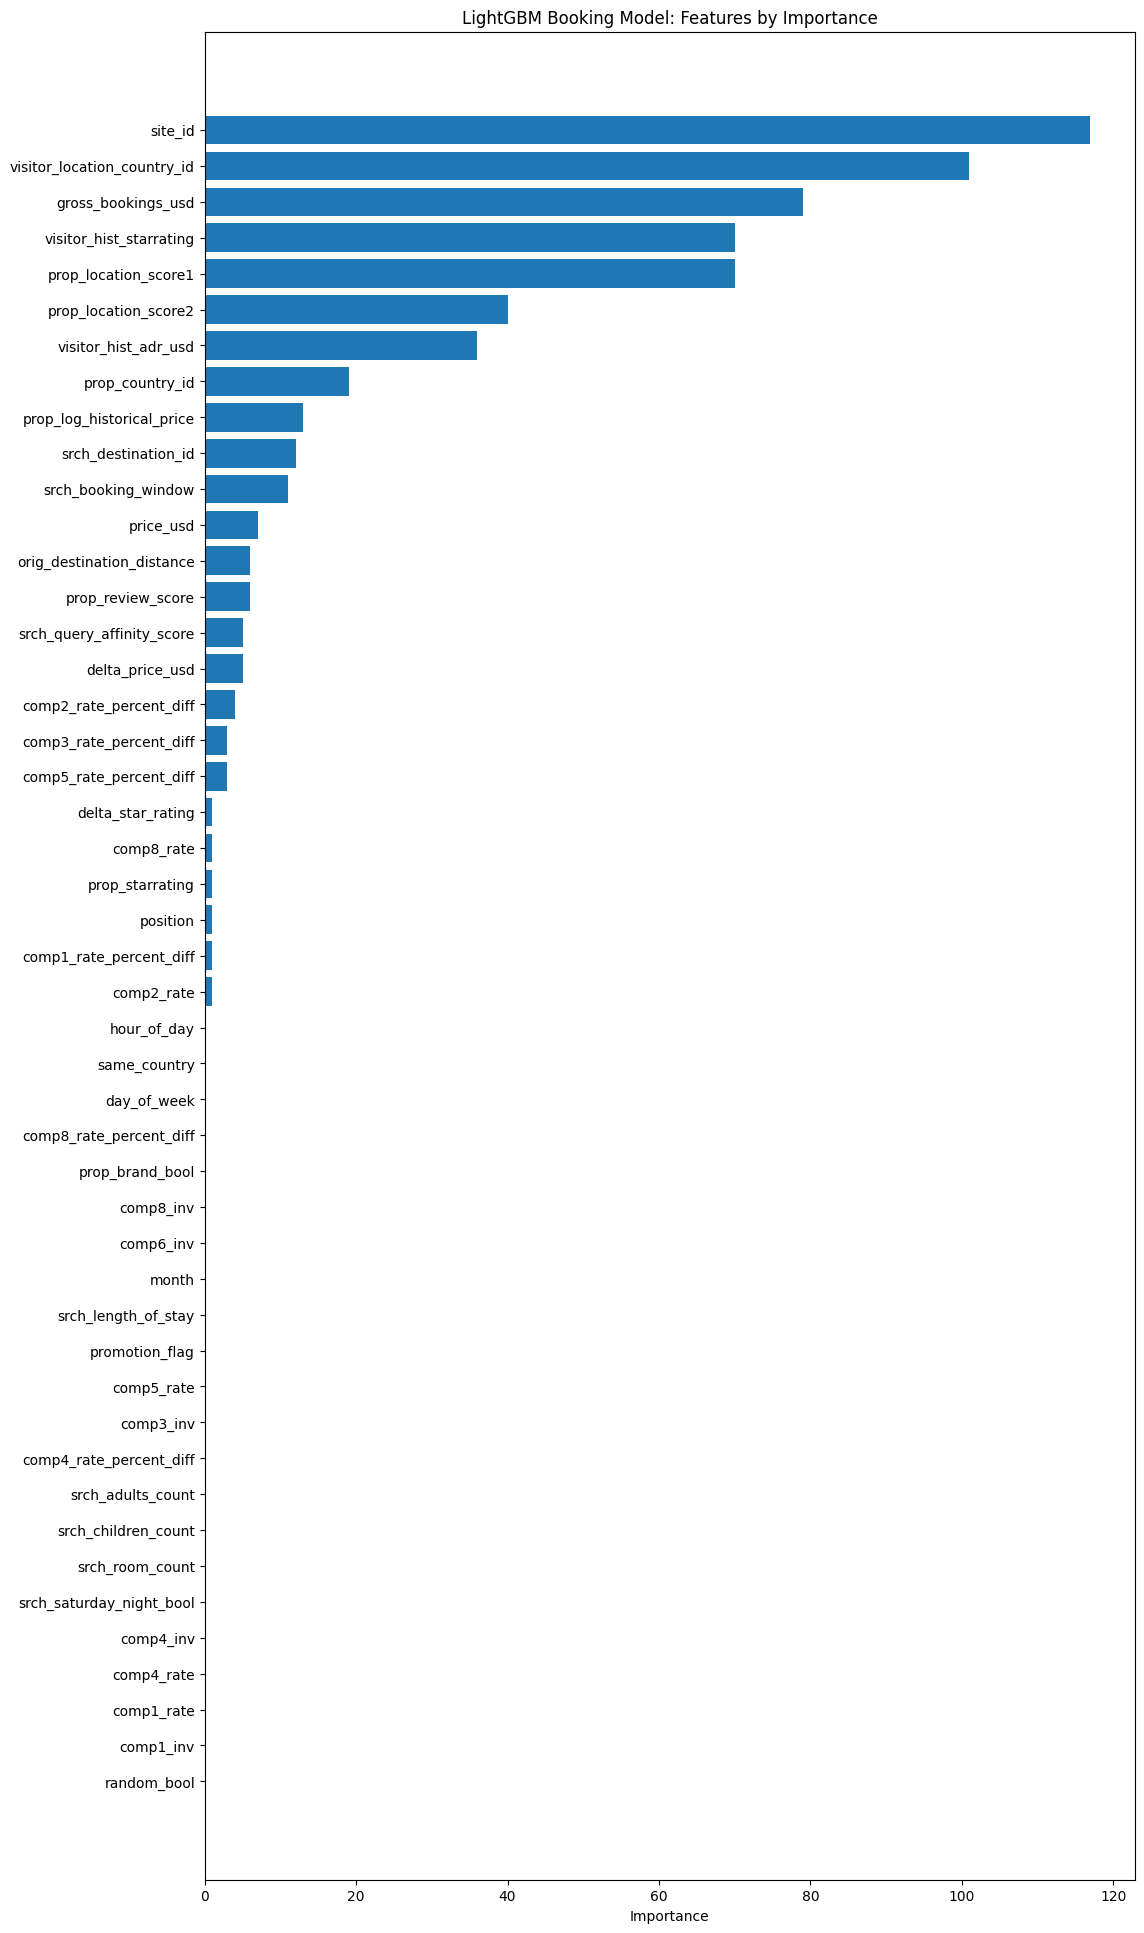

In [ ]:
import matplotlib.pyplot as plt

#Set the size of the plot
plt.figure(figsize=(12, 24))  # Adjust the width and height to suit your display needs

#Sorting the indices of the features by importance
sorted_idx = LGBMbook.feature_importances_.argsort()

#Create a horizontal bar plot
plt.barh(X_train.columns[sorted_idx], LGBMbook.feature_importances_[sorted_idx])
plt.xlabel("Importance")
plt.title("LightGBM Booking Model: Features by Importance")

#Show the plot
plt.show()


In [ ]:
# Check for any missing or additional columns in df_test
print("Missing in df_test:", set(X_train.columns) - set(df_test.columns))
print("Extra in df_test:", set(df_test.columns) - set(X_train.columns))


Missing in df_test: {'hour_of_day', 'position', 'gross_bookings_usd', 'month', 'delta_star_rating', 'day_of_week', 'delta_price_usd', 'same_country'}
Extra in df_test: {'comp2_inv', 'comp6_rate_percent_diff', 'srch_id', 'comp6_rate', 'comp7_rate_percent_diff', 'comp3_rate', 'comp7_rate', 'comp7_inv', 'prop_id', 'comp5_inv', 'date_time'}


In [ ]:
print(X_train.shape)
print(df_test.shape)
print(X_train.columns)
print(df_test.columns)


(4958347, 47)
(4959183, 50)
Index(['site_id', 'visitor_location_country_id', 'visitor_hist_starrating',
       'visitor_hist_adr_usd', 'prop_country_id', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'position',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_rate_percent_diff', 'comp3_inv', 'comp3_rate_percent_diff',
       'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate',
       'comp5_rate_percent_diff', 'comp6_inv', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'gross_bookings_usd', 'day_of_week', 'month',
       'hour_o

In [ ]:
df_test = df_test.drop('date_time', axis=1)


In [ ]:
results = create_submission(LGBMclick,LGBMbook,df_test, proba = True)

~ Making predictions
/tmp/ipykernel_117/1111438751.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x*2 if x > 0 else x)
/tmp/ipykernel_117/1111438751.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['total'] = sub['click_preds']+sub['booking_preds']
/tmp/ipykernel_117/1111438751.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
results[1]

,srch_id,prop_id,total
0,1,78599,0.093781
1,1,63894,0.091632
2,1,82231,0.091632
3,1,73666,0.091281
4,1,3180,0.091140
...,...,...,...
4959178,332787,32019,0.064244
4959179,332787,33959,0.062967
4959180,332787,99509,0.059700
4959181,332787,29018,0.057613


In [ ]:
results[0]

,srch_id,prop_id
0,1,78599
1,1,63894
2,1,82231
3,1,73666
4,1,3180
...,...,...
4959178,332787,32019
4959179,332787,33959
4959180,332787,99509
4959181,332787,29018


In [ ]:
results[0].to_csv('Kaggle_Submission.csv',index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2c4d580-0670-4443-9265-5d094bb23253' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>